# ReThink Media Twitter API

This notebook is for the development and exploration of code for ReThink Media's Twitter API Python interface. The main goals of this notebook are:

- Search Tweets: query, date (optional)
  - Past seven days
  - Past 30 days
  - Full archive
  - Language = English
- Collect Tweets in .csv file
- Add data visualization
  - Top hashtags, keywords, influencers
  - Volume over time for queries/topics

In [ ]:
# importing necessary modules
from dotenv import load_dotenv
import os
import json
import numpy as np
import pandas as pd
import tweepy

load_dotenv()

## Utility Functions

Functions for general use across the different analysis functions within the notebook.

In [1]:
# function to parse Twitter API v2 response into a DataFrame of Tweet data
def tweet_df(df, response, tweet_fields):
    
    # looping through each Tweet in response, parsing data
    for i in range(len(response[0])):
        tweet = response[0][i]
        tweet_id = tweet.id
        tweet_data = {}
        for field in tweet_fields:
            if tweet[field]:
                tweet_data[field] = tweet[field]
                
                # extracting hashtags from "entities" field and adding it as its own column
                if field == "entities":
                    try:
                        hashtag_data = tweet[field]['hashtags']
                        hashtags = [hashtag['tag'] for hashtag in hashtag_data]
                        tweet_data['entities_hashtags'] = hashtags
                    except KeyError:
                        tweet_data['entities_hashtags'] = None
                
                # separating metrics from "public_metrics" field and adding them as their own column
                if field == "public_metrics":
                    metrics = list(tweet[field].keys())
                    for metric in metrics:
                        tweet_data[metric] = tweet[field][metric]
                
            else:
                tweet_data[field] = None
                if field == "entities":
                    tweet_data['entities_hashtags'] = None
        
        df.loc[tweet_id] = tweet_data
    
    return df

In [2]:
# function to add follower counts to DataFrame of Tweet data
# designed to be called after the Tweet data has been parsed with tweet_df()
def author_data(api_2, df):
    num_users = 0
    author_ids = df["author_id"].unique().tolist()
    users = []
    while num_users < len(author_ids):
        
        # slicing tweet_ids since API v2 get_users only takes max 100 ID's per request
        try:
            slice_ids = author_ids[num_users:num_users+100]
        except IndexError:
            slice_ids = author_ids[num_users:]
        
        # retrieving user data through API v2, adding responses to users list
        user_fields = ["public_metrics", "verified"]
        response = api_2.get_users(ids=slice_ids, usernames=None, user_fields=user_fields)
        users.extend(response[0])
        num_users += len(response[0])
    
    # mapping author_id to follower counts and verified status, adding to DataFrame
    followers_count = {user['id']: user['public_metrics']['followers_count'] for user in users}
    verified = {user['id']: user['verified'] for user in users}
    df["author_followers_count"] = df["author_id"].map(followers_count)
    df["author_verified"] = df["author_id"].map(verified)
    
    return df

## Authentication

The variables below are what allow access to the Twitter API. I've defined them in a `.env` file, and I'm retrieving them with the code below. We then pass those variables in to a tweepy client in order to instantiate a Twitter API instance.

In [ ]:
# retrieving environment variables
consumer_key = os.getenv("API_KEY")
consumer_secret = os.getenv("API_KEY_SECRET")
bearer_token = os.getenv("BEARER_TOKEN")
access_token = os.getenv("ACCESS_TOKEN")
access_secret = os.getenv("ACCESS_SECRET")

In [ ]:
# Twitter API authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [3]:
# function to initialize Twitter API v1.1 instance (for 30-day and full archive search)
def init_api_1():
    
    # importing necessary modules and loading .env file
    from dotenv import load_dotenv
    import os
    import tweepy
    load_dotenv()
    
    # retrieving environment variables from .env file
    consumer_key = os.getenv("API_KEY")
    consumer_secret = os.getenv("API_KEY_SECRET")
    bearer_token = os.getenv("BEARER_TOKEN")
    access_token = os.getenv("ACCESS_TOKEN")
    access_secret = os.getenv("ACCESS_SECRET")
    
    # Twitter API authentication
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    
    # instantiating Twitter API v1.1 reference
    api_1 = tweepy.API(auth, wait_on_rate_limit=True)
    
    return api_1

In [4]:
# function to initialize Twitter API v2 instance (for 7-day search)
def init_api_2():
    # importing necessary modules and loading .env file
    from dotenv import load_dotenv
    import os
    import tweepy
    load_dotenv()
    
    # retrieving environment variables from .env file
    consumer_key = os.getenv("API_KEY")
    consumer_secret = os.getenv("API_KEY_SECRET")
    bearer_token = os.getenv("BEARER_TOKEN")
    access_token = os.getenv("ACCESS_TOKEN")
    access_secret = os.getenv("ACCESS_SECRET")
    
    # instantiating Twitter API v2 reference
    api_2 = tweepy.Client(bearer_token=bearer_token,
                         consumer_key=consumer_key,
                         consumer_secret=consumer_secret,
                         access_token=access_token,
                         access_token_secret=access_secret,
                         wait_on_rate_limit=True)
    
    return api_2

## Recent Search

The search function available to us in the Standard API package restricts our search to the past seven days, without a premium API dev subscription. For searches further back in the archive, we need to subscribe to a premium API dev environment or upgrade to the Academic API package, which is given to researchers with a clear thesis or research paper goal in mind.

The query can be 512 characters maximum, and the user can specify a `start_time` and `end_time` (as `datetime` or `str` objects) within the past seven days. The user can also search for hashtags as well. The default behavior for white space is "AND" joins, e.g., hello world = hello AND world. More information about Twitter API queries can be found [in their documentation](https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query).

The 7-day search can receive an unlimited number of requests and 500,000 Tweets per month.

The 7-day search has a query character limit of 512 characters.

The `response` object is a tuple, and it consists of four items: `(data, includes, errors, meta)`.

The `data` object contains the Tweets that are retrieved, and `meta` is the metadata for those Tweets. In this reponse object, `includes` and `errors` are empty, so I'm not sure what `includes` is yet.

In [5]:
# function to retrieve Tweets from the past 7 days relevant to a query
def search_7(query, start_date=None, end_date=None, max_results=20, write_csv=False, filename="search_7.csv"):
    
    # initializing API v1.1 instance
    api_2 = init_api_2()
    
    # parsing dates passed into function
    from dateutil import parser
    if start_date:
        start_date = parser.parse(start_date)
    if end_date:
        end_date = parser.parse(end_date)
    
    # setting Tweet data to be included in response
    tweet_fields = ["text", "attachments", "author_id", "context_annotations", "conversation_id", "created_at",
                   "entities", "geo", "in_reply_to_user_id", "lang", "public_metrics", "referenced_tweets"]
    
    # initializing variables for API calls and DataFrame for Tweet data
    import pandas as pd
    next_token = None
    num_results = 0
    tweets = pd.DataFrame(columns=tweet_fields+
                          ['entities_hashtags','retweet_count','reply_count','like_count','quote_count'])
    tweets.index.name = "Tweet ID"
    
    # aggregating multiple pages of query results
    import tweepy
    paginator_results = tweepy.Paginator(api_2.search_recent_tweets,
                                 query=f"{query} lang:en",
                                 start_time=start_date,
                                 end_time=end_date,
                                 tweet_fields=tweet_fields
                                ).flatten(max_results)
    
    # collecting tweets in a format acceptable by tweet_df()
    response = [[tweet for tweet in paginator_results]]
        
    # adding Tweet data to DataFrame
    tweets = tweet_df(tweets, response, tweet_fields)
    num_results = len(tweets)

    # dropping "public_metrics" since all the values are unpacked, adding "total_engagements"
    tweets.drop('public_metrics', axis=1, inplace=True)
    total_engagements = tweets["retweet_count"] + tweets["reply_count"] + tweets["like_count"] + tweets["quote_count"]
    tweets["total_engagements"] = total_engagements
    
    # adding follower count and verified status to DataFrame for influence metrics
    tweets = author_data(api_2, tweets)
    
    # writing Tweet DataFrame to csv file
    if write_csv:
        tweets.to_csv(filename)
    
    return tweets

In [8]:
import time
start = time.time()
test = search_7("hello world", max_results=18000, write_csv=True)
end = time.time()
print(f"Time taken: {(end-start)/60} min")
test

Rate limit exceeded. Sleeping for 818 seconds.


KeyboardInterrupt: 

In [34]:
import tweepy
api_2 = init_api_2()
count = api_2.get_recent_tweets_count("hello world lang:en", granularity='day')
count

Response(data=[{'end': '2021-10-23T00:00:00.000Z', 'start': '2021-10-22T18:26:46.000Z', 'tweet_count': 1208}, {'end': '2021-10-24T00:00:00.000Z', 'start': '2021-10-23T00:00:00.000Z', 'tweet_count': 15567}, {'end': '2021-10-25T00:00:00.000Z', 'start': '2021-10-24T00:00:00.000Z', 'tweet_count': 6428}, {'end': '2021-10-26T00:00:00.000Z', 'start': '2021-10-25T00:00:00.000Z', 'tweet_count': 7049}, {'end': '2021-10-27T00:00:00.000Z', 'start': '2021-10-26T00:00:00.000Z', 'tweet_count': 7832}, {'end': '2021-10-28T00:00:00.000Z', 'start': '2021-10-27T00:00:00.000Z', 'tweet_count': 6718}, {'end': '2021-10-29T00:00:00.000Z', 'start': '2021-10-28T00:00:00.000Z', 'tweet_count': 11190}, {'end': '2021-10-29T18:26:46.000Z', 'start': '2021-10-29T00:00:00.000Z', 'tweet_count': 7352}], includes={}, errors=[], meta={'total_tweet_count': 63344})

## 30-Day/Full Archive Search

We can access 30-day and full archive searches without an Academic API package with a premium development environment through the Twitter API. This requires interfacing with the API v1.1, as opposed to v2 in the Recent Search.

The 30-day search can receive 250 requests and 25,000 Tweets per month, while the full archive search can receive 50 requests and 5,000 Tweets per month.

Both 30-day and full archive searches have a query character limit of 256 characters.

The `tweepy.models.Status` object contains a lot of data about the Tweet, such as its text, its author, and various aspects of metadata about the Tweet's creation and interactions.

In [7]:
# function to search Tweets within the past 30 days
# utilizes both API v1.1 and v2 to be consistent with 7-day search.
def search_30(query, start_date=None, end_date=None, max_results=20, write_csv=False, filename="search_30.csv"):
    # initializing API v1.1 instance
    api_1 = init_api_1()
    
    # parsing dates passed into function
    from dateutil import parser
    if start_date:
        start_date = parser.parse(start_date)
    if end_date:
        end_date = parser.parse(end_date)
    
    # retrieving Tweets from the past 30 days relevant to query using tweepy's pagination function
    import tweepy
    response_1 = tweepy.Cursor(api_1.search_30_day,
                               label="30day",
                               query=f"{query} lang:en",
                               fromDate=start_date,
                               toDate=end_date
                              ).items(max_results)
    
    # gathering Tweet ID's in a list
    tweet_ids = [tweet._json['id'] for tweet in response_1]
    
    # setting Tweet data to be included in response
    tweet_fields = ["text", "attachments", "author_id", "context_annotations", "conversation_id", "created_at",
                   "entities", "geo", "in_reply_to_user_id", "lang", "public_metrics", "referenced_tweets"]
    
    # initializing variables for API calls and DataFrame for Tweet data
    import pandas as pd
    num_results = 0
    tweets = pd.DataFrame(columns=tweet_fields+
                          ['entities_hashtags','retweet_count','reply_count','like_count','quote_count'])    
    tweets.index.name = "Tweet ID"
    
    # loop to retrieve Tweets from ID's through API v2, 100 at a time
    api_2 = init_api_2()
    while num_results < max_results:
        # slicing tweet_ids since API v2 get_tweets only takes max 100 ID's per request
        try:
            slice_ids = tweet_ids[num_results:num_results+100]
        except IndexError:
            slice_ids = tweet_ids[num_results:]
        
        # retrieving Tweet data from API v2 and adding to DataFrame
        response_2 = api_2.get_tweets(slice_ids, tweet_fields=tweet_fields)
        tweets = tweet_df(tweets, response_2, tweet_fields)
        num_results = len(tweets)
    
    # dropping "public_metrics" since all the values are unpacked, adding "total_engagements"
    tweets.drop('public_metrics', axis=1, inplace=True)
    total_engagements = tweets["retweet_count"] + tweets["reply_count"] + tweets["like_count"] + tweets["quote_count"]
    tweets["total_engagements"] = total_engagements
    
    # adding follower count and verified status to DataFrame for influence metrics
    tweets = author_data(api_2, tweets)
    
    # writing Tweet DataFrame to csv file
    if write_csv:
        tweets.to_csv(filename)
    
    return tweets

In [8]:
test30 = search_30("hello world", max_results=150, write_csv=True)
test30

,text,attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,in_reply_to_user_id,lang,referenced_tweets,entities_hashtags,retweet_count,reply_count,like_count,quote_count,total_engagements,author_followers_count,author_verified
Tweet ID,,,,,,,,,,,,,,,,,,,
1454129634333769728,HELLO TWITTER WORLD!\n#firsttweet,None,1453617640748969986,"[{'domain': {'id': '46', 'name': 'Brand Catego...",1454129634333769728,2021-10-29 16:54:55+00:00,"{'hashtags': [{'start': 21, 'end': 32, 'tag': ...",None,None,en,None,[firsttweet],0,0,0,0,0,0,False
1454129599504334851,@katyperry @TheEllenShow @lukebryan @MichaelJW...,{'media_keys': ['3_1453623156032385029']},767852641925861376,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1452745813847777280,2021-10-29 16:54:47+00:00,"{'hashtags': [{'start': 122, 'end': 132, 'tag'...",None,21447363,en,"[(type, id)]","[SudanCoup, مليونية30اكتوبر]",0,0,0,0,0,3385,False
1454129532672385029,"@rembeauty @ArianaGrande Hello World, Demonstr...",{'media_keys': ['3_1453623156032385029']},767852641925861376,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1453709014584500229,2021-10-29 16:54:31+00:00,"{'hashtags': [{'start': 94, 'end': 104, 'tag':...",None,1292897129090801664,en,"[(type, id)]","[SudanCoup, مليونية30اكتوبر]",0,0,0,0,0,3385,False
1454129528180142081,RT @dailybluenight: 151030 (on adele’s “hello...,None,780317786367139840,None,1454129528180142081,2021-10-29 16:54:30+00:00,"{'mentions': [{'start': 3, 'end': 18, 'usernam...",None,None,en,"[(type, id)]",None,43,0,0,0,43,500,False
1454129513273647114,RT @houseof_rare: Hello World! 👋\n\nWe are Hou...,None,1415022990887198727,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",1454129513273647114,2021-10-29 16:54:27+00:00,"{'hashtags': [{'start': 62, 'end': 70, 'tag': ...",None,None,en,"[(type, id)]","[startup, NFT]",166,0,0,0,166,83,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454120176660586503,RT @kchartsmaster: Hello world\nhttps://t.co/Y...,{'media_keys': ['7_1426975931533385730']},1386949147547160576,None,1454120176660586503,2021-10-29 16:17:21+00:00,"{'mentions': [{'start': 3, 'end': 17, 'usernam...",None,None,en,"[(type, id)]",None,325,0,0,0,325,96,False
1454119967197073412,"hello world .,",None,40204139,None,1454119967197073412,2021-10-29 16:16:31+00:00,None,None,None,en,None,None,0,0,0,0,0,10,False
1454119871101370371,RT @cillegargas: OMYGASH AM I SEEING THIS RIGH...,None,754538092225101825,None,1454119871101370371,2021-10-29 16:16:08+00:00,"{'mentions': [{'start': 3, 'end': 15, 'usernam...",None,None,en,"[(type, id)]",None,4,0,0,0,4,487,False


In [9]:
# function to search Tweets within the past 30 days
# utilizes both API v1.1 and v2 to be consistent with 7-day search.
def search_full(query, start_date=None, end_date=None, max_results=20, write_csv=False, filename="search_full.csv"):
    # initializing API v1.1 instance
    api_1 = init_api_1()
    
    # parsing dates passed into function
    from dateutil import parser
    if start_date:
        start_date = parser.parse(start_date)
    if end_date:
        end_date = parser.parse(end_date)
    
    # retrieving Tweets from the past 30 days relevant to query using tweepy's pagination function
    import tweepy
    response_1 = tweepy.Cursor(api_1.search_full_archive,
                               label="full",
                               query=f"{query} lang:en",
                               fromDate=start_date,
                               toDate=end_date
                              ).items(max_results)
    
    # gathering Tweet ID's in a list
    tweet_ids = [tweet._json['id'] for tweet in response_1]
    
    # setting Tweet data to be included in response
    tweet_fields = ["text", "attachments", "author_id", "context_annotations", "conversation_id", "created_at",
                   "entities", "geo", "in_reply_to_user_id", "lang", "public_metrics", "referenced_tweets"]
    
    # initializing variables for API calls and DataFrame for Tweet data
    import pandas as pd
    num_results = 0
    tweets = pd.DataFrame(columns=tweet_fields+
                          ['entities_hashtags','retweet_count','reply_count','like_count','quote_count'])
    tweets.index.name = "Tweet ID"
    
    # loop to retrieve Tweets from ID's through API v2, 100 at a time
    api_2 = init_api_2()
    while num_results < max_results:
        # slicing tweet_ids since API v2 get_tweets only takes max 100 ID's per request
        try:
            slice_ids = tweet_ids[num_results:num_results+100]
        except IndexError:
            slice_ids = tweet_ids[num_results:]
        
        # retrieving Tweet data from API v2 and adding to DataFrame
        response_2 = api_2.get_tweets(slice_ids, tweet_fields=tweet_fields)
        tweets = tweet_df(tweets, response_2, tweet_fields)
        num_results = len(tweets)
    
    # dropping "public_metrics" since all the values are unpacked, adding "total_engagements"
    tweets.drop('public_metrics', axis=1, inplace=True)
    total_engagements = tweets["retweet_count"] + tweets["reply_count"] + tweets["like_count"] + tweets["quote_count"]
    tweets["total_engagements"] = total_engagements
    
    # adding follower count and verified status to DataFrame for influence metrics
    tweets = author_data(api_2, tweets)
    
    # writing Tweets DataFrame to csv file
    if write_csv:
        tweets.to_csv(filename)
    
    return tweets

In [10]:
test_full = search_full("hello world", max_results=150, write_csv=True)
test_full

,text,attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,in_reply_to_user_id,lang,referenced_tweets,entities_hashtags,retweet_count,reply_count,like_count,quote_count,total_engagements,author_followers_count,author_verified
Tweet ID,,,,,,,,,,,,,,,,,,,
1454129634333769728,HELLO TWITTER WORLD!\n#firsttweet,None,1453617640748969986,"[{'domain': {'id': '46', 'name': 'Brand Catego...",1454129634333769728,2021-10-29 16:54:55+00:00,"{'hashtags': [{'start': 21, 'end': 32, 'tag': ...",None,None,en,None,[firsttweet],0,0,0,0,0,0,False
1454129599504334851,@katyperry @TheEllenShow @lukebryan @MichaelJW...,{'media_keys': ['3_1453623156032385029']},767852641925861376,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1452745813847777280,2021-10-29 16:54:47+00:00,"{'urls': [{'start': 256, 'end': 279, 'url': 'h...",None,21447363,en,"[(type, id)]","[SudanCoup, مليونية30اكتوبر]",0,0,0,0,0,3385,False
1454129532672385029,"@rembeauty @ArianaGrande Hello World, Demonstr...",{'media_keys': ['3_1453623156032385029']},767852641925861376,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1453709014584500229,2021-10-29 16:54:31+00:00,"{'urls': [{'start': 228, 'end': 251, 'url': 'h...",None,1292897129090801664,en,"[(type, id)]","[SudanCoup, مليونية30اكتوبر]",0,0,0,0,0,3385,False
1454129528180142081,RT @dailybluenight: 151030 (on adele’s “hello...,None,780317786367139840,None,1454129528180142081,2021-10-29 16:54:30+00:00,"{'mentions': [{'start': 3, 'end': 18, 'usernam...",None,None,en,"[(type, id)]",None,43,0,0,0,43,500,False
1454129513273647114,RT @houseof_rare: Hello World! 👋\n\nWe are Hou...,None,1415022990887198727,"[{'domain': {'id': '45', 'name': 'Brand Vertic...",1454129513273647114,2021-10-29 16:54:27+00:00,"{'hashtags': [{'start': 62, 'end': 70, 'tag': ...",None,None,en,"[(type, id)]","[startup, NFT]",166,0,0,0,166,83,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454120176660586503,RT @kchartsmaster: Hello world\nhttps://t.co/Y...,{'media_keys': ['7_1426975931533385730']},1386949147547160576,None,1454120176660586503,2021-10-29 16:17:21+00:00,"{'urls': [{'start': 31, 'end': 54, 'url': 'htt...",None,None,en,"[(type, id)]",None,325,0,0,0,325,96,False
1454119967197073412,"hello world .,",None,40204139,None,1454119967197073412,2021-10-29 16:16:31+00:00,None,None,None,en,None,None,0,0,0,0,0,10,False
1454119871101370371,RT @cillegargas: OMYGASH AM I SEEING THIS RIGH...,None,754538092225101825,None,1454119871101370371,2021-10-29 16:16:08+00:00,"{'mentions': [{'start': 3, 'end': 15, 'usernam...",None,None,en,"[(type, id)]",None,4,0,0,0,4,487,False


## Stream

A Stream is an object that can filter and sample realtime Tweets. Since it's a real-time stream, this is probably not what we're looking for in an analysis pipeline.

In [ ]:
# instantiating Stream object
stream = tweepy.Stream(consumer_key, consumer_secret, access_token, access_secret)
stream

In [ ]:
stream.sample(languages=["en"])

## Word Clouds

Creating word clouds for common keywords and hashtags within the Tweet DataFrames.

In [58]:
def word_cloud(df, query=None, save_imgs=False):
    # combining DataFrame text column into one long string, doing some initial pre-processing
    import pandas as pd
    tweet_text = " ".join(df["text"])
    tweet_text = tweet_text.lower()
    tweet_text = tweet_text.replace("\n", " ")
    
    # splitting string into list of words, removing hashtags, usernames, links, and retweet indicator
    word_list = tweet_text.split(" ")
    hash_list = [word for word in word_list if word.startswith("#")]
    user_list = [word for word in word_list if word.startswith("@")]
    link_list = [word for word in word_list if word.startswith("http")]
    word_list = [word for word in word_list if word not in hash_list + user_list + link_list]
    word_list = [word for word in word_list if word != "rt"]
    
    # using nltk tokenizer to further pre-process text, removing non-alpha words
    from nltk.tokenize import word_tokenize
    import nltk
    nltk.download('punkt')
    tweet_text = " ".join(word_list)
    word_list = word_tokenize(tweet_text)
    word_list = [word for word in word_list if word.isalpha()]
    
    # joining list of words into final cleaned string
    tweet_text = " ".join(word_list)
    
    # generating word cloud
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt

    stopwords = set(STOPWORDS)
    
    # adding words from query to stop words so they don't show up in the word cloud
    if query:
        stopwords.update(query.split())

    # word cloud for text
    words_fig = plt.figure()
    word_cloud = WordCloud(background_color="white", width=3000, height=2000, max_font_size=400,
                           max_words=100, prefer_horizontal=1.0, stopwords=stopwords)
    word_cloud.generate(tweet_text)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    if save_imgs:
        word_cloud.to_file("wordcloud.png")

    # word cloud for hashtags
    hash_fig = plt.figure()
    word_cloud = WordCloud(background_color="white", width=3000, height=2000,
                           max_words=100, prefer_horizontal=1.0, stopwords=stopwords)
    word_cloud.generate(" ".join(hash_list))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    if save_imgs:
        word_cloud.to_file("hashtags.png")
    
    return words_fig, hash_fig

[nltk_data] Downloading package punkt to /home/lana-e/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


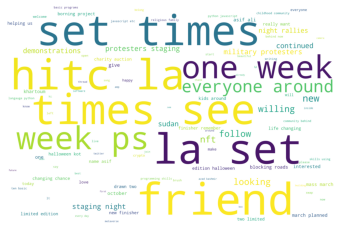

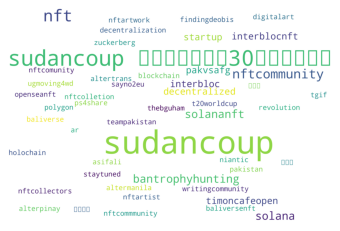

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

In [59]:
word_cloud(test, query="hello world", save_imgs=True)

## Attention over time plots:

Creating a daily track of Tweet volume relevant to a query. Takes the DataFrame from the search functions as an input, and outputs a graph figure.

In [69]:
test

,text,attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,in_reply_to_user_id,lang,referenced_tweets,entities_hashtags,retweet_count,reply_count,like_count,quote_count,total_engagements,author_followers_count,author_verified
Tweet ID,,,,,,,,,,,,,,,,,,,
1454163888333676544,RT @88rising: Hello friends. YOUR HITC LA SET ...,None,1188852976028274688,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1454163888333676544,2021-10-29 19:11:02+00:00,"{'urls': [{'start': 77, 'end': 100, 'url': 'ht...",None,None,en,"[(type, id)]",None,1601,0,0,0,1601,266,False
1454163830762786826,hello world i desire karl jacobs and kurtis co...,None,1248465752362905602,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1454163830762786826,2021-10-29 19:10:48+00:00,"{'annotations': [{'start': 21, 'end': 31, 'pro...",None,None,en,None,None,0,0,0,0,0,6001,False
1454163807249391616,RT @88rising: Hello friends. YOUR HITC LA SET ...,None,1662700284,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1454163807249391616,2021-10-29 19:10:43+00:00,"{'urls': [{'start': 77, 'end': 100, 'url': 'ht...",None,None,en,"[(type, id)]",None,1601,0,0,0,1601,671,False
1454163803306962946,"RT @Algaddalarchive: Hello World, Demonstratio...",None,1270753095425961985,None,1454163803306962946,2021-10-29 19:10:42+00:00,"{'mentions': [{'start': 3, 'end': 19, 'usernam...",None,None,en,"[(type, id)]",[SudanCoup],46,0,0,0,46,4663,False
1454163789184602121,RT @88rising: Hello friends. YOUR HITC LA SET ...,None,1188263551,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1454163789184602121,2021-10-29 19:10:39+00:00,"{'urls': [{'start': 77, 'end': 100, 'url': 'ht...",None,None,en,"[(type, id)]",None,1601,0,0,0,1601,635,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453739244166389761,RT @ForrevaEiEn: Photos of each band's first p...,None,1103528751164416005,"[{'domain': {'id': '130', 'name': 'Multimedia ...",1453739244166389761,2021-10-28 15:03:39+00:00,"{'mentions': [{'start': 3, 'end': 15, 'usernam...",None,None,en,"[(type, id)]",None,262,0,0,0,262,34,False
1453739233215086594,"RT @HourlyKuma: Hello Kumanifers, this is a ho...",None,1420995696061140994,None,1453739233215086594,2021-10-28 15:03:37+00:00,"{'annotations': [{'start': 72, 'end': 79, 'pro...",None,None,en,"[(type, id)]",None,845,0,0,0,845,1,False
1453739213711630336,RT @TheSplitParty: @oxCoyneFlipxo Hello Lewis!...,None,1409308692156194816,"[{'domain': {'id': '30', 'name': 'Entities [En...",1453739213711630336,2021-10-28 15:03:32+00:00,"{'annotations': [{'start': 40, 'end': 44, 'pro...",None,None,en,"[(type, id)]",None,1,0,0,0,1,1253,False


In [71]:
daily_counts = test.groupby(test["created_at"].dt.date).count()
daily_counts

,text,attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,in_reply_to_user_id,lang,referenced_tweets,entities_hashtags,retweet_count,reply_count,like_count,quote_count,total_engagements,author_followers_count,author_verified
created_at,,,,,,,,,,,,,,,,,,,
2021-10-28,3232,709,3232,1692,3232,3232,2960,14,539,3232,2337,1249,3232,3232,3232,3232,3232,3232,3232
2021-10-29,6768,1296,6768,3487,6768,6768,5877,25,894,6768,5070,1606,6768,6768,6768,6768,6768,6768,6768


([<matplotlib.axis.XTick at 0x7fc1a6faba90>,
 [Text(0, 0, ''), Text(0, 0, '')])

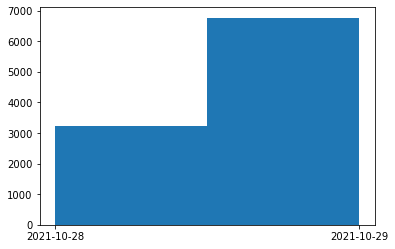

In [121]:
import matplotlib.pyplot as plt
plt.hist(test["created_at"].dt.date, bins=len(test["created_at"].dt.date.unique()), align="mid")
plt.xticks(test["created_at"].dt.date.unique())

In [83]:
daily_counts.index

Index([2021-10-28, 2021-10-29], dtype='object', name='created_at')

In [108]:
test["created_at"].dt.date.unique()

array([datetime.date(2021, 10, 29), datetime.date(2021, 10, 28)],
      dtype=object)